# Anomaly Detection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.io import loadmat
from scipy import stats
from ipykernel import kernelapp as app
from scipy.optimize import minimize

In [2]:
data = loadmat('./data/ex8data1.mat')
X = data['X']
X.shape

(307, 2)

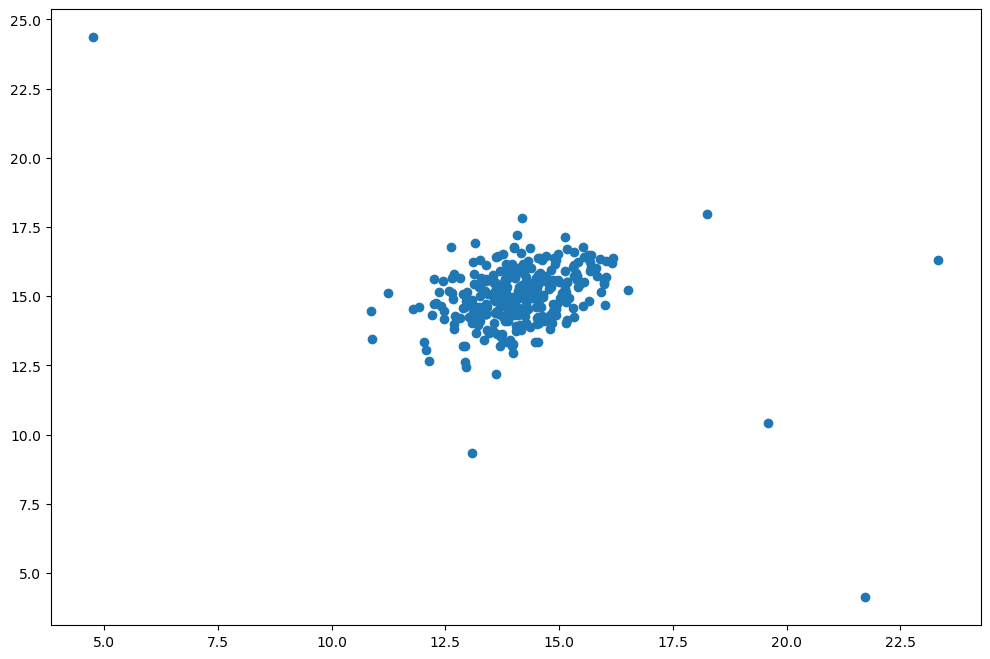

In [3]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X[:,0], X[:,1])
plt.show()

## Normal Distribution
$$
p\left(x ; \mu, \sigma^{2}\right)=\frac{1}{\sqrt{2 \pi \sigma^{2}}} e^{-\frac{(x-\mu)^{2}}{2 \sigma^{2}}}
$$
$$
\mu_{i}=\frac{1}{m} \sum_{j=1}^{m} x_{i}^{(j)}
$$
$$
\sigma_{i}^{2}=\frac{1}{m} \sum_{j=1}^{m}\left(x_{i}^{(j)}-\mu_{i}\right)^{2}
$$

In [4]:
def estimate_gaussian(X):
    mu = X.mean(axis=0)
    sigma = X.var(axis=0) 
    
    return mu, sigma

In [5]:
mu, sigma = estimate_gaussian(X)
mu, sigma

(array([14.11222578, 14.99771051]), array([1.83263141, 1.70974533]))

In [6]:
Xval = data['Xval']
yval = data['yval']

Xval.shape, yval.shape

((307, 2), (307, 1))

In [7]:
dist = stats.norm(mu[0], sigma[0])
dist.pdf(15)  

0.1935875044615038

In [8]:
dist.pdf(X[:,0])[0:50]

array([0.183842  , 0.20221694, 0.21746136, 0.19778763, 0.20858956,
       0.21652359, 0.16991291, 0.15123542, 0.1163989 , 0.1594734 ,
       0.21716057, 0.21760472, 0.20141857, 0.20157497, 0.21711385,
       0.21758775, 0.21695576, 0.2138258 , 0.21057069, 0.1173018 ,
       0.20765108, 0.21717452, 0.19510663, 0.21702152, 0.17429399,
       0.15413455, 0.21000109, 0.20223586, 0.21031898, 0.21313426,
       0.16158946, 0.2170794 , 0.17825767, 0.17414633, 0.1264951 ,
       0.19723662, 0.14538809, 0.21766361, 0.21191386, 0.21729442,
       0.21238912, 0.18799417, 0.21259798, 0.21752767, 0.20616968,
       0.21520366, 0.1280081 , 0.21768113, 0.21539967, 0.16913173])

In [9]:
p = np.zeros((X.shape[0], X.shape[1]))
p[:,0] = stats.norm(mu[0], sigma[0]).pdf(X[:,0])
p[:,1] = stats.norm(mu[1], sigma[1]).pdf(X[:,1])

p.shape

(307, 2)

## Evaluation
$$
F_{1}=\frac{2 \cdot \text { Prec } \cdot R e c}{\text {Prec}+R e c}
$$
$$
\begin{aligned} \text {Precision} &=\frac{TP}{TP + FP} \\ Recall &=\frac{TP}{TP+FN} \end{aligned}
$$

In [10]:
def select_threshold(p, yval): 
    best_epsilon = 0
    best_f1 = 0
    f1 = 0
    
    step = (p.max() - p.min()) / 1000
    
    for epsilon in np.arange(p.min(), p.max(), step):
        preds = p < epsilon   
        
        tp = np.sum(np.logical_and(preds == 1, yval == 1)).astype(float)   
        fp = np.sum(np.logical_and(preds == 1, yval == 0)).astype(float)
        fn = np.sum(np.logical_and(preds == 0, yval == 1)).astype(float)
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = (2 * precision * recall) / (precision + recall)
        
        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = epsilon
    
    return best_epsilon, best_f1

In [11]:
epsilon, f1 = select_threshold(p, yval)
epsilon, f1

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_6616\247553942.py:15: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


(0.05109992785293987, 0.6666666666666667)

In [12]:
# indexes of the values considered to be outliers
outliers = np.where(p < epsilon) 
outliers

(array([147, 170, 300, 301, 301, 303, 303, 304, 305, 305, 306, 306],
       dtype=int64),
 array([0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1], dtype=int64))

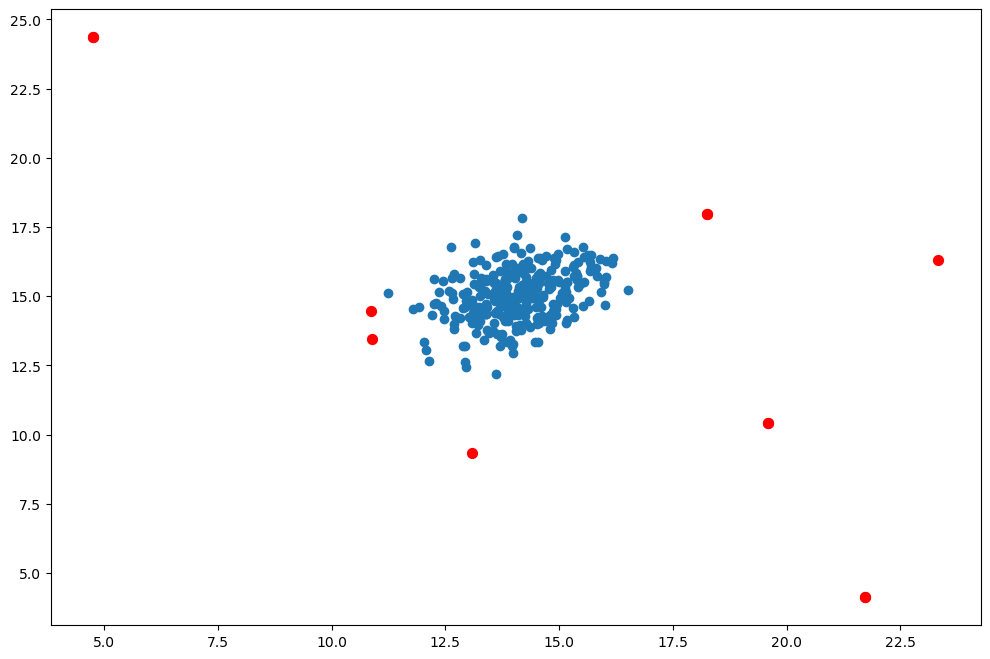

In [13]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X[:,0], X[:,1])
ax.scatter(X[outliers[0],0], X[outliers[0],1], s=50, color='r', marker='o') #marker：散点的形状参数，marker='o'：圈
plt.show()

## Collaborative filtering

In [14]:
data = loadmat('./data/ex8_movies.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Dec  1 17:19:26 2011',
 '__version__': '1.0',
 '__globals__': [],
 'Y': array([[5, 4, 0, ..., 5, 0, 0],
        [3, 0, 0, ..., 0, 0, 5],
        [4, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'R': array([[1, 1, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 0, 0, 1],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [15]:
Y = data['Y']
R = data['R']
Y.shape, R.shape

((1682, 943), (1682, 943))

In [16]:
Y[1,np.where(R[1,:]==1)[0]].mean()


3.2061068702290076

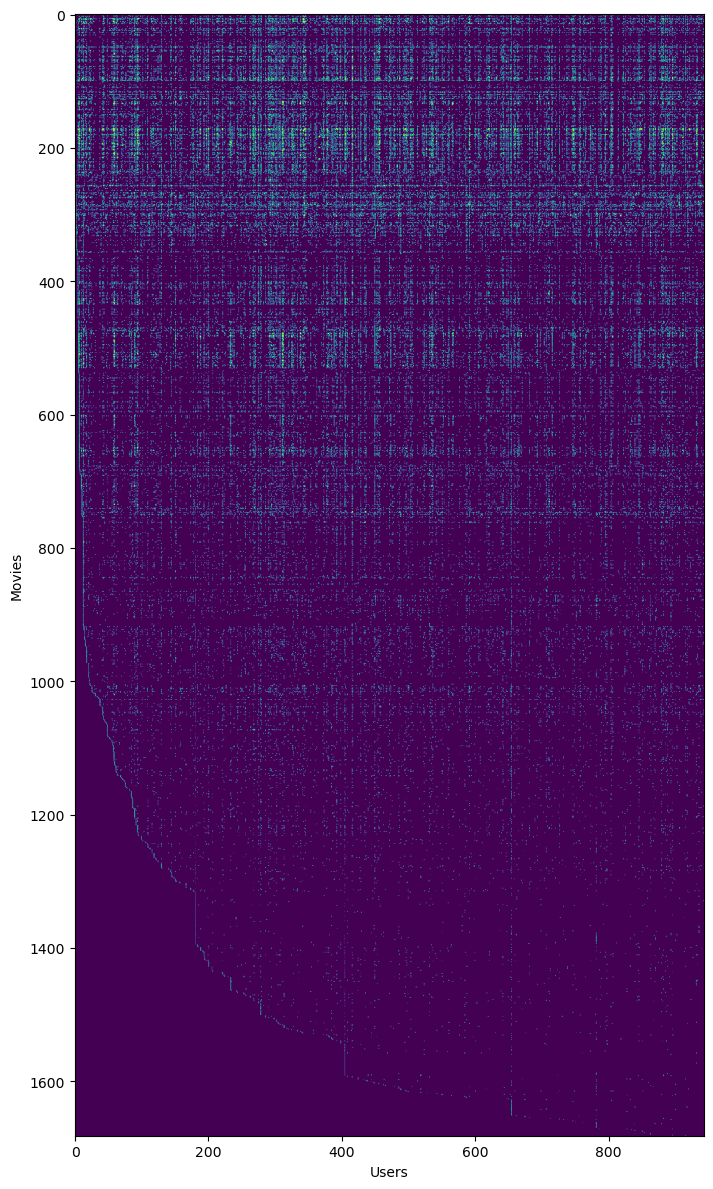

In [17]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(Y)
ax.set_xlabel('Users')
ax.set_ylabel('Movies')
fig.tight_layout() 

plt.show()

##  Cost function
When R(i, j) = 1,
$$
J\left(x^{(1)}, \ldots, x^{\left(n_{m}\right)}, \theta^{(1)}, \ldots, \theta^{\left(n_{u}\right)}\right)=\frac{1}{2} \sum_{(i, j) : r(i, j)=1}\left(\left(\theta^{(j)}\right)^{T} x^{(i)}-y^{(i, j)}\right)^{2}
$$


In [18]:
def cost(params, Y, R, num_features):
    Y = np.matrix(Y)  # (1682, 943)
    R = np.matrix(R)  # (1682, 943)
    num_movies = Y.shape[0]
    num_users = Y.shape[1]
    
    # reshape the parameter array into parameter matrices
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features)))  # (1682, 10)
    Theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))  # (943, 10)
    
    # initializations
    J = 0
    
    # compute the cost
    error = np.multiply((X * Theta.T) - Y, R)  # (1682, 943)
    squared_error = np.power(error, 2)  # (1682, 943)
    J = (1. / 2) * np.sum(squared_error)
    
    return J

In [19]:
params_data = loadmat('./data/ex8_movieParams.mat')
X = params_data['X']
Theta = params_data['Theta']
X.shape, Theta.shape

((1682, 10), (943, 10))

In [20]:
users = 4
movies = 5
features = 3

X_sub = X[:movies, :features]
Theta_sub = Theta[:users, :features]
Y_sub = Y[:movies, :users]
R_sub = R[:movies, :users]


params = np.concatenate((np.ravel(X_sub), np.ravel(Theta_sub)))

cost(params, Y_sub, R_sub, features)

22.224603725685675

## Gradient Descent
When R(i, j) = 1,
$$
\left(\mathrm{X}_{\mathrm{grad}}(\mathrm{i}, :)\right)^{T}=\left[\begin{array}{c}{\frac{\partial J}{\partial x_{i}^{(i)}}} \\ {\frac{\partial J}{\partial x_{2}^{(i)}}} \\ {\vdots} \\ {\frac{\partial J}{\partial x_{n}^{(i)}}}\end{array}\right]=\sum_{j : r(i, j)=1}\left(\left(\theta^{(j)}\right)^{T} x^{(i)}-y^{(i, j)}\right) \theta^{(j)}
$$

In [21]:
def cost(params, Y, R, num_features):
    Y = np.matrix(Y)  # (1682, 943)
    R = np.matrix(R)  # (1682, 943)
    num_movies = Y.shape[0]
    num_users = Y.shape[1]
    
    # reshape the parameter array into parameter matrices
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features)))  # (1682, 10)
    Theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))  # (943, 10)
    
    # initializations
    J = 0
    X_grad = np.zeros(X.shape)  # (1682, 10)
    Theta_grad = np.zeros(Theta.shape)  # (943, 10)
    
    # compute the cost
    error = np.multiply((X * Theta.T) - Y, R)  # (1682, 943)
    squared_error = np.power(error, 2)  # (1682, 943)
    J = (1. / 2) * np.sum(squared_error)
    
    # calculate the gradients
    X_grad = error * Theta
    Theta_grad = error.T * X
    
    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(X_grad), np.ravel(Theta_grad)))
    
    return J, grad

In [22]:
J, grad = cost(params, Y_sub, R_sub, features)
J, grad

(22.224603725685675,
 array([ -2.52899165,   7.57570308,  -1.89979026,  -0.56819597,
          3.35265031,  -0.52339845,  -0.83240713,   4.91163297,
         -0.76677878,  -0.38358278,   2.26333698,  -0.35334048,
         -0.80378006,   4.74271842,  -0.74040871, -10.5680202 ,
          4.62776019,  -7.16004443,  -3.05099006,   1.16441367,
         -3.47410789,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ]))

## Regularized Cost Function
$$
\begin{aligned} J\left(x^{(1)}, \ldots, x^{\left(n_{m}\right)}, \theta^{(1)}, \ldots, \theta^{\left(n_{u}\right)}\right)=\frac{1}{2} & \sum_{(i, j) : r(i, j)=1}\left(\left(\theta^{(j)}\right)^{T} x^{(i)}-y^{(i, j)}\right)^{2}+\\ &\left(\frac{\lambda}{2} \sum_{j=1}^{n_{u}} \sum_{k=1}^{n}\left(\theta_{k}^{(j)}\right)^{2}\right)+\left(\frac{\lambda}{2} \sum_{i=1}^{n_{m}} \sum_{k=1}^{n}\left(x_{k}^{(i)}\right)^{2}\right) \end{aligned}
$$

##  Regularized Gradient Descent
$$
\begin{aligned} \frac{\partial J}{\partial x_{k}^{(i)}} &=\sum_{j : r(i, j)=1}\left(\left(\theta^{(j)}\right)^{T} x^{(i)}-y^{(i, j)}\right) \theta_{k}^{(j)}+\lambda x_{k}^{(i)} \\ \frac{\partial J}{\partial \theta_{k}^{(j)}} &=\sum_{i : r(i, j)=1}\left(\left(\theta^{(j)}\right)^{T} x^{(i)}-y^{(i, j)}\right) x_{k}^{(i)}+\lambda \theta_{k}^{(j)} \end{aligned}
$$

In [23]:
def cost(params, Y, R, num_features, learning_rate):
    Y = np.matrix(Y)  # (1682, 943)
    R = np.matrix(R)  # (1682, 943)
    num_movies = Y.shape[0]
    num_users = Y.shape[1]
    
    # reshape the parameter array into parameter matrices
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features)))  # (1682, 10)
    Theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))  # (943, 10)
    
    # initializations
    J = 0
    X_grad = np.zeros(X.shape)  # (1682, 10)
    Theta_grad = np.zeros(Theta.shape)  # (943, 10)
    
    # compute the cost
    error = np.multiply((X * Theta.T) - Y, R)  # (1682, 943)
    squared_error = np.power(error, 2)  # (1682, 943)
    J = (1. / 2) * np.sum(squared_error)
    
    # add the cost regularization
    J = J + ((learning_rate / 2) * np.sum(np.power(Theta, 2)))
    J = J + ((learning_rate / 2) * np.sum(np.power(X, 2)))
    
    # calculate the gradients with regularization
    X_grad = (error * Theta) + (learning_rate * X)
    Theta_grad = (error.T * X) + (learning_rate * Theta)
    
    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(X_grad), np.ravel(Theta_grad)))
    
    return J, grad

In [24]:
J, grad = cost(params, Y_sub, R_sub, features, 1.5)
J, grad

(31.34405624427422,
 array([ -0.95596339,   6.97535514,  -0.10861109,   0.60308088,
          2.77421145,   0.25839822,   0.12985616,   4.0898522 ,
         -0.89247334,   0.29684395,   1.06300933,   0.66738144,
          0.60252677,   4.90185327,  -0.19747928, -10.13985478,
          2.10136256,  -6.76563628,  -2.29347024,   0.48244098,
         -2.99791422,  -0.64787484,  -0.71820673,   1.27006666,
          1.09289758,  -0.40784086,   0.49026541]))

In [26]:
movie_idx = {}
f = open('./data/movie_ids.txt',encoding= 'gbk')
for line in f:
    tokens = line.split(' ')
    tokens[-1] = tokens[-1][:-1]

    movie_idx[int(tokens[0]) - 1] = ' '.join(tokens[1:])

In [27]:
movie_idx[0]

'Toy Story (1995)'

In [30]:
# Rating for practice

ratings = np.zeros((1682, 1))

ratings[0] = 4
ratings[6] = 3
ratings[11] = 5
ratings[53] = 4
ratings[63] = 5
ratings[65] = 3
ratings[68] = 5
ratings[97] = 2
ratings[182] = 4
ratings[225] = 5
ratings[354] = 5

#format是格式化字符串函数,{0}和{1}对应着format括号内的元素
print('Rated {0} with {1} stars.'.format(movie_idx[0], str(int(ratings[0])))) 
print('Rated {0} with {1} stars.'.format(movie_idx[6], str(int(ratings[6]))))
print('Rated {0} with {1} stars.'.format(movie_idx[11], str(int(ratings[11]))))
print('Rated {0} with {1} stars.'.format(movie_idx[53], str(int(ratings[53]))))
print('Rated {0} with {1} stars.'.format(movie_idx[63], str(int(ratings[63]))))
print('Rated {0} with {1} stars.'.format(movie_idx[65], str(int(ratings[65]))))
print('Rated {0} with {1} stars.'.format(movie_idx[68], str(int(ratings[68]))))
print('Rated {0} with {1} stars.'.format(movie_idx[97], str(int(ratings[97]))))
print('Rated {0} with {1} stars.'.format(movie_idx[182], str(int(ratings[182]))))
print('Rated {0} with {1} stars.'.format(movie_idx[225], str(int(ratings[225]))))
print('Rated {0} with {1} stars.'.format(movie_idx[354], str(int(ratings[354]))))

Rated Toy Story (1995) with 4 stars.
Rated Twelve Monkeys (1995) with 3 stars.
Rated Usual Suspects, The (1995) with 5 stars.
Rated Outbreak (1995) with 4 stars.
Rated Shawshank Redemption, The (1994) with 5 stars.
Rated While You Were Sleeping (1995) with 3 stars.
Rated Forrest Gump (1994) with 5 stars.
Rated Silence of the Lambs, The (1991) with 2 stars.
Rated Alien (1979) with 4 stars.
Rated Die Hard 2 (1990) with 5 stars.
Rated Sphere (1998) with 5 stars.


In [31]:
R = data['R']
Y = data['Y']

Y = np.append(Y, ratings, axis=1) 
R = np.append(R, ratings != 0, axis=1)

Y.shape, R.shape, ratings.shape

((1682, 944), (1682, 944), (1682, 1))

In [32]:
movies = Y.shape[0]  # 1682
users = Y.shape[1]  # 944
features = 10
learning_rate = 10.

X = np.random.random(size=(movies, features)) 
Theta = np.random.random(size=(users, features))
params = np.concatenate((np.ravel(X), np.ravel(Theta)))

X.shape, Theta.shape, params.shape

((1682, 10), (944, 10), (26260,))

In [33]:
Ymean = np.zeros((movies,  1))
Ynorm = np.zeros((movies, users))

for i in range(movies):
    idx = np.where(R[i,:] == 1)[0]  
    Ymean[i] = Y[i,idx].mean()  
    Ynorm[i,idx] = Y[i,idx] - Ymean[i] 

Ynorm.mean()

5.507036456515984e-19

In [34]:
fmin = minimize(fun=cost, x0=params, args=(Ynorm, R, features, learning_rate), 
                method='CG', jac=True, options={'maxiter': 100})
fmin

 message: Maximum number of iterations has been exceeded.
 success: False
  status: 1
     fun: 38953.029148426634
       x: [ 2.203e-02  7.205e-01 ...  2.363e-02  1.877e-01]
     nit: 100
     jac: [-1.665e-02 -1.039e-02 ...  1.261e-03  2.060e-04]
    nfev: 141
    njev: 141

In [35]:
X = np.matrix(np.reshape(fmin.x[:movies * features], (movies, features)))
Theta = np.matrix(np.reshape(fmin.x[movies * features:], (users, features)))

X.shape, Theta.shape

((1682, 10), (944, 10))

In [36]:
predictions = X * Theta.T 
my_preds = predictions[:, -1] + Ymean 
my_preds.shape

(1682, 1)

In [37]:
sorted_preds = np.sort(my_preds, axis=0)[::-1]
sorted_preds[:10] 

matrix([[5.00000233],
        [5.0000019 ],
        [5.00000044],
        [5.00000038],
        [5.00000016],
        [5.00000013],
        [5.00000011],
        [5.0000001 ],
        [5.00000008],
        [5.00000001]])

In [38]:
idx = np.argsort(my_preds, axis=0)[::-1] 

idx

matrix([[1535],
        [1188],
        [1200],
        ...,
        [1485],
        [1625],
        [1407]], dtype=int64)

In [39]:
print("Top 10 movie predictions:")
for i in range(10):
    j = int(idx[i])
    print('Predicted rating of {0} for movie {1}.'.format(str(float(my_preds[j])), movie_idx[j]))

Top 10 movie predictions:
Predicted rating of 5.000002332667281 for movie Aiqing wansui (1994).
Predicted rating of 5.0000018996512585 for movie Prefontaine (1997).
Predicted rating of 5.000000440481025 for movie Marlene Dietrich: Shadow and Light (1996) .
Predicted rating of 5.000000375600839 for movie Great Day in Harlem, A (1994).
Predicted rating of 5.000000161836906 for movie Star Kid (1997).
Predicted rating of 5.00000013191352 for movie Santa with Muscles (1996).
Predicted rating of 5.000000108167846 for movie Saint of Fort Washington, The (1993).
Predicted rating of 5.000000098139824 for movie They Made Me a Criminal (1939).
Predicted rating of 5.000000080579226 for movie Someone Else's America (1995).
Predicted rating of 5.000000011695169 for movie Entertaining Angels: The Dorothy Day Story (1996).
